In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import igraph
import matplotlib.patches as patches
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
sc.set_figure_params()
scf.set_figure_pubready()

from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list("aspect",["lightgrey","white","red"])

import numpy as np
import igraph
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

def plot_updown(adata,ndots=3,ntops=4,key=None,cmap="RdBu_r",rev=False,style="italic",rotation=0,gglst=None,link_seg=False):
    gglst=adata.var_names if gglst is None else gglst
    graph = adata.uns["graph"]

    dct = graph["milestones"]
    keys = np.array(list(dct.keys()))
    vals = np.array(list(dct.values()))

    edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
    img = igraph.Graph(directed=True)
    img.add_vertices(vals.astype(str))
    img.add_edges(edges)

    allpaths=img.get_all_shortest_paths(str(graph["root"]),to=graph["tips"].astype(str))

    allpaths=np.array(allpaths)[np.argsort(np.array([len(p) for p in allpaths]))]

    order=allpaths[0]
    for i in range(1,len(allpaths)):
        order=order+np.array(allpaths[i])[~np.isin(allpaths[i],order)].tolist()

    order=np.array(order)[1:]

    order=pd.Series(graph["milestones"].keys(),index=graph["milestones"].values())[np.array(img.vs["name"])[order].astype(int)]
    order=pd.Series(range(len(adata.obs.seg.cat.categories)),index=graph["pp_seg"]["to"])[order.index].values
    
    if rev:
        order = order[::-1]

    vs2mils=pd.Series(dct.keys(),index=dct.values())

    #gglst=adata.var_names

    def get_seg(s):
        start=adata.obs.milestones[adata.obs.t[s.index].idxmin()]
        end=adata.obs.milestones[adata.obs.t[s.index].idxmax()]
        return pd.DataFrame([adata[s.index[s==c],gglst].X.A.mean(axis=0) for c in [start,end]],
                             index=[start,end],columns=gglst).T
    
    def get_seg(s):
        return pd.DataFrame([adata[s.index[s==i],gglst].X.A.mean(axis=0) for i in s.cat.categories],
                             index=s.cat.categories,columns=gglst).T
    
    cellsel=[adata.obs.milestones[adata.obs.seg==s] for s in adata.obs.seg.cat.categories[order]]
    cellsel=[pd.cut(adata.obs.t[adata.obs.seg==s],ndots) for s in adata.obs.seg.cat.categories[order]]

    res=pd.concat([get_seg(s) for s in cellsel],axis=1)
    res=(res.T/res.max(axis=1).values).T*200

    res=res.iloc[::-1,:]
    from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
    import matplotlib.cm as cm

    fig, axs = plt.subplots(
        1,
        len(order),
        constrained_layout=True,
        sharey=True,
        figsize=(ndots*len(order) / 3, 2*len(gglst) / 7)

    )
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    pos=np.arange(len(order),0,-1)
    caxs = []
    for i,s in enumerate(np.arange(0,len(order)*ndots,ndots)):
        tocomp=res.iloc[:,s:s+ndots]
        if rev:
            tocomp=tocomp.iloc[:,::-1]
        xs = np.arange(tocomp.shape[0])
        ys = np.arange(tocomp.shape[1])
        X, Y = np.meshgrid(xs, ys)
        
        ss=int(adata.obs.seg.cat.categories[order[i]][0])
        sel=adata.obs.milestones.cat.categories==vs2mils[graph["pp_seg"].loc[ss]["from"]]
        start=np.array(adata.uns["milestones_colors"])[sel][0]
        sel=adata.obs.milestones.cat.categories==vs2mils[graph["pp_seg"].loc[ss]["to"]]
        end=np.array(adata.uns["milestones_colors"])[sel][0]

        from matplotlib.colors import LinearSegmentedColormap
        
        m2m=[end,start] if rev else [start,end]
        my_cm=LinearSegmentedColormap.from_list("aspect",m2m)
        
        axs[i].scatter(
            Y, X, s=tocomp.values.T,c=tocomp.values.T,cmap=cmap,edgecolors='k',linewidth=.5
        )
        axs[i].grid(b=None)
        axs[i].set_yticks(range(tocomp.shape[0]));
        if rotation == 0:
            axs[i].set_yticklabels(gglst[::-1],style=style)
        else:
            axs[i].set_yticklabels(gglst[::-1],style=style,rotation=rotation,va="bottom",ha="right");
        axs[i].set_xticks([])
        axs[i].set_xlim([-0.5, tocomp.shape[1] - 0.5])
        axs[i].set_ylim([-0.5, tocomp.shape[0] - 0.5])

        divider = make_axes_locatable(axs[i])
        cax = divider.new_vertical(size=.2, pad=0.05, pack_start=False)
        caxs.append(cax)
        mappable = cm.ScalarMappable(cmap=my_cm)

        fig.add_axes(cax)
        cbar=fig.colorbar(mappable, cax=cax,orientation='horizontal')
        cbar.set_ticks([])
        
    if link_seg:
        caxs_dct = dict(zip([adata.obs.seg.cat.categories[o] for o in order], caxs))

        kw = dict(
            arrowprops=dict(
                arrowstyle="<|-",
                facecolor="k",
                connectionstyle="bar,fraction=-.2",
                shrinkA=0.1,
            ),
            zorder=0,
            va="center",
            xycoords="axes fraction",
            annotation_clip=False,
        )

        kwclose = dict(
            arrowprops=dict(
                arrowstyle="<|-",
                facecolor="k",
                connectionstyle="bar,fraction=-1",
                shrinkA=0.1,
            ),
            zorder=0,
            va="center",
            xycoords="axes fraction",
            annotation_clip=False,
        )

        pp_seg = adata.uns["graph"]["pp_seg"]

        dsts = pd.Series(range(len(caxs_dct)), index=caxs_dct.keys())
        for s, cax in caxs_dct.items():
            fro = pp_seg.loc[int(s), "from"]
            to = pp_seg.loc[int(s), "to"]
            for n in pp_seg.index[pp_seg["from"] == to]:
                if (dsts[str(n)] - dsts[s]) < -1:
                    cax.annotate("", xy=[0, 1], xytext=[-1.4, 1], **kw)
                else:
                    cax.annotate("", xy=[0, 1], xytext=[-0.2, 1], **kwclose)

    #plt.savefig("figures/dotplot_updown.svg")

In [106]:
adata=sc.read("data/adata_scenic.h5ad")

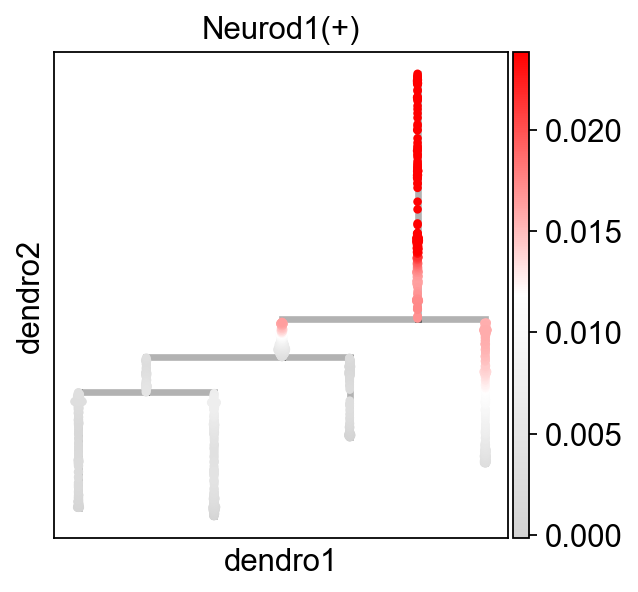

In [107]:
scf.pl.dendrogram(adata,color="Neurod1(+)",cmap=cmap,tree_behind=True,layer="fitted",
                  vmax=adata[adata.obs.regime=="maturation","Neurod1(+)"].layers["fitted"].max())

In [45]:
bounds = [0, 0.1, .2]
style_color = [[212,212,212],[255,255,255],[243, 21, 29]]

color_arr = []
for color in style_color:
    rgb = [float(value)/255 for value in color]
    color_arr.append(rgb)

# normalize bound values
norm = mpl.colors.Normalize(vmin=min(bounds), vmax=max(bounds))
normed_vals = norm(bounds)

# create a colormap
cmap = LinearSegmentedColormap.from_list(
'my_palette',
list(zip(normed_vals, color_arr)),
N=256
)

In [47]:
normed_vals

masked_array(data=[0. , 0.5, 1. ],
             mask=False,
       fill_value=1e+20)

In [46]:
list(zip(normed_vals, color_arr[:-1]))

[(0.0, [0.8313725490196079, 0.8313725490196079, 0.8313725490196079]),
 (0.5, [1.0, 1.0, 1.0])]

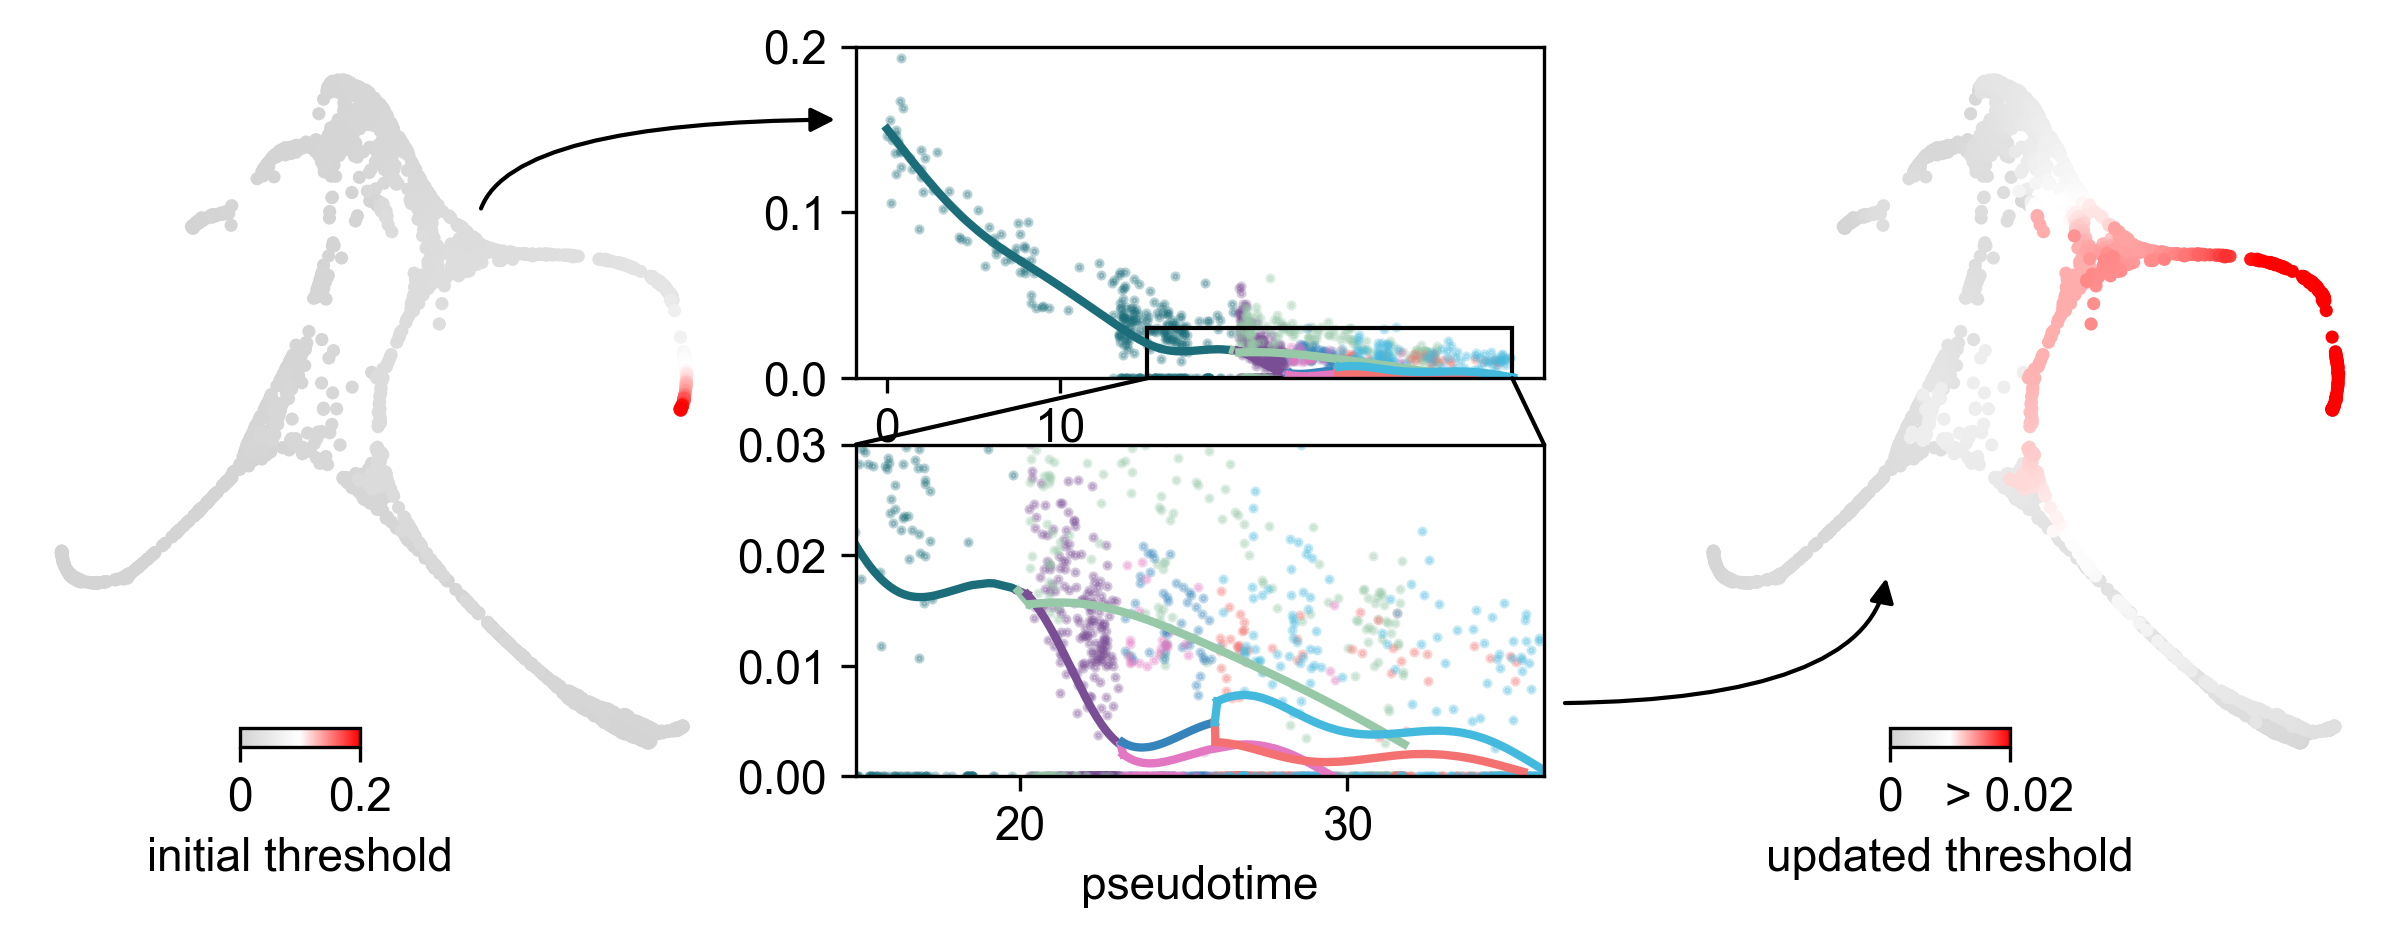

In [199]:
from matplotlib.patches import ConnectionPatch, Rectangle
import matplotlib.gridspec as gridspec
import scvelo as scv
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
scv.set_figure_params(frameon=False,figsize=(3.5,3.5),dpi=150,dpi_save=600)

fig = plt.figure(figsize=(10,3.2))

gs0 = gridspec.GridSpec(1, 3, figure=fig)

axA = fig.add_subplot(gs0[0])
scv.pl.draw_graph(adata,color="Neurod1(+)",cmap=cmap,layer="fitted",title="",show=False,colorbar=False,ax=axA)

cax = fig.add_axes([0.25, 0.18, 0.04, 0.02],)


cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                orientation='horizontal'  ,                    
                                ticks=[0,1],
                                label="initial threshold"
                                )

cb1.ax.set_xticklabels(['0', '0.2'])

axA.annotate("",
                xy=(0.65, .75), xycoords='axes fraction',
                xytext=(1.2, .9), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<|-", color="k",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),
                )

gs00 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs0[1],hspace=0.2)

ax0 = fig.add_subplot(gs00[0])

#fig,axs=plt.subplots(2,1)
scf.pl.single_trend(adata,"Neurod1(+)",plot_emb=False,show=False,ax_trend=ax0)
ax0.set_ylim([0,.2])
ax0.set_xticks([0,10])
ax0.grid(b=False)
ax0.set_ylabel("")
ax0.set_xlabel("")
rec=Rectangle((15,0),21,0.03,fill=None, alpha=1)
ax0.add_artist(rec)

ax1 = fig.add_subplot(gs00[1])
scf.pl.single_trend(adata,"Neurod1(+)",plot_emb=False,show=False,ax_trend=ax1)
ax1.set_xlim([15,36])
ax1.set_ylim([0,0.03])

con1 = ConnectionPatch(xyA=(15, 0), coordsA="data", 
                       xyB=(15, 0.03), coordsB="data", axesA=ax0,axesB=ax1)
ax1.add_artist(con1)
con1 = ConnectionPatch(xyA=(36, 0), coordsA="data", 
                       xyB=(36, 0.03), coordsB="data", axesA=ax0,axesB=ax1)
ax1.add_artist(con1)
ax1.grid(b=False)
ax1.set_ylabel("")

axB = fig.add_subplot(gs0[2])
scv.pl.draw_graph(adata,color="Neurod1(+)",cmap=cmap,layer="fitted",title="",show=False,colorbar=False,ax=axB,
                  vmax=adata[adata.obs.regime=="maturation","Neurod1(+)"].layers["fitted"].max())


cax = fig.add_axes([.8, 0.18, 0.04, 0.02],)


cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                orientation='horizontal'  ,                    
                                ticks=[0,1],
                                label="updated threshold")

cb1.ax.set_xticklabels(['0', '> 0.02'])

axB.annotate("",
                xy=(0.3, .3), xycoords='axes fraction',
                xytext=(-.2, .1), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="-|>", color="k",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),
                )
plt.savefig("figures/fig3_auc_neurod.pdf",bbox_inches="tight")

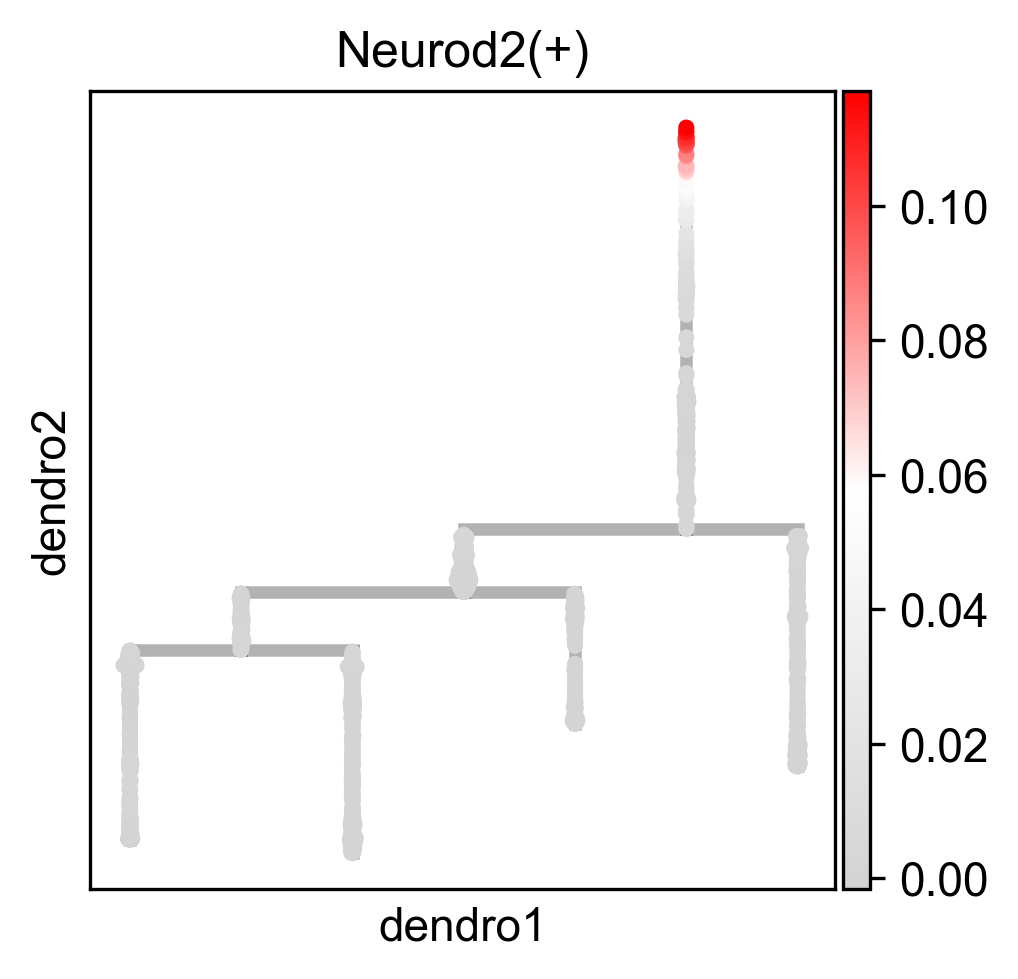

In [57]:
scf.pl.dendrogram(adata,color="Neurod2(+)",cmap=cmap,tree_behind=True,layer="fitted")

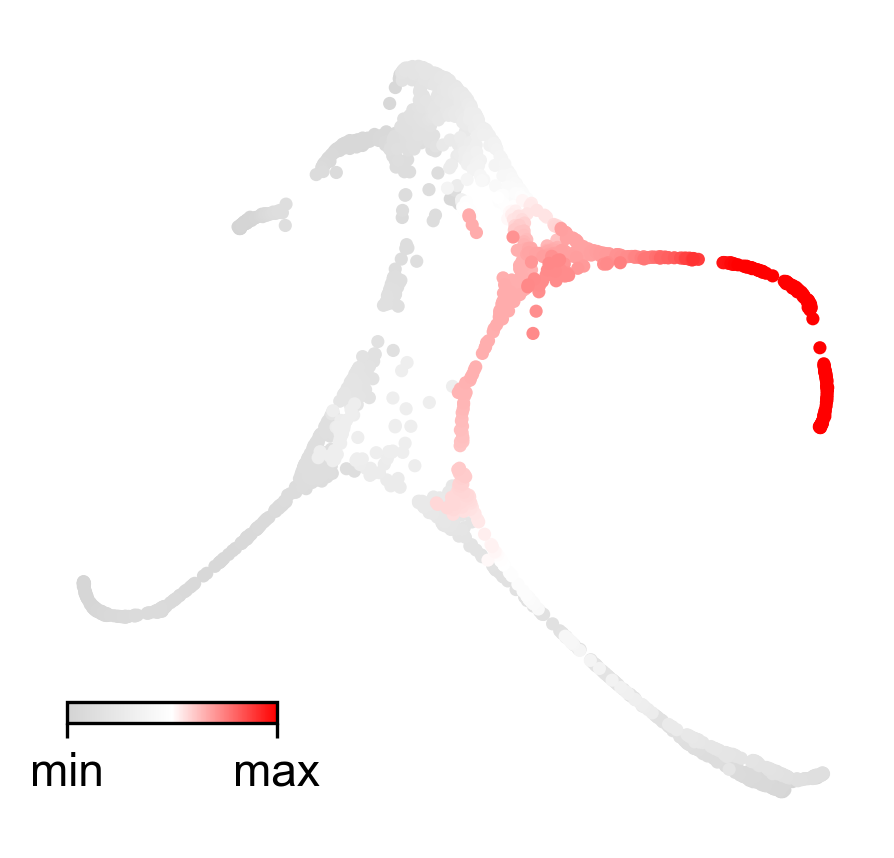

In [6]:
import scvelo as scv
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
scv.set_figure_params(frameon=False,figsize=(3.5,3.5),dpi=150,dpi_save=600)
fig, ax = plt.subplots(figsize=(3.5,3.5))

scv.pl.draw_graph(adata,color="Neurod1(+)",cmap=cmap,layer="fitted",title="",show=False,colorbar=False,ax=ax,
                  vmax=adata[adata.obs.regime=="maturation","Neurod1(+)"].layers["fitted"].max())
#ax.set_title("Neurod1(+)",style="italic",size=18)
cax = fig.add_axes([0.2, 0.25, 0.2, 0.02],)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                orientation='horizontal'  ,                    
                                ticks=[0,1]
                                )
cb1.set_ticklabels(["min","max"])
plt.savefig("figures/fig3-B.pdf",bbox_inches="tight")

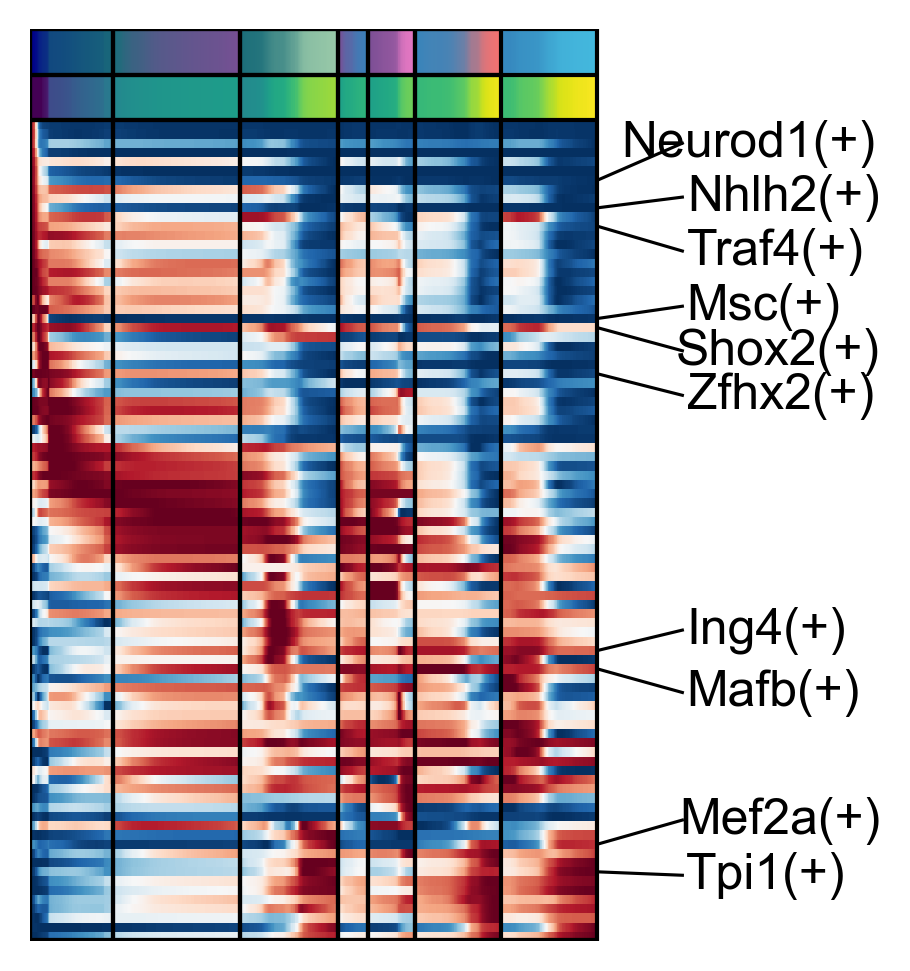

In [7]:
scf.pl.trends(adata,plot_emb=False,ordering="max",
              annot="milestones",ord_thre=.95,
              fontsize=12,save_genes="ordered_regulons.tsv")

In [8]:
catorder=adata.obs.milestones.cat.categories

In [9]:
import scipy.sparse as sp
adata.X = sp.csr_matrix(adata.X)

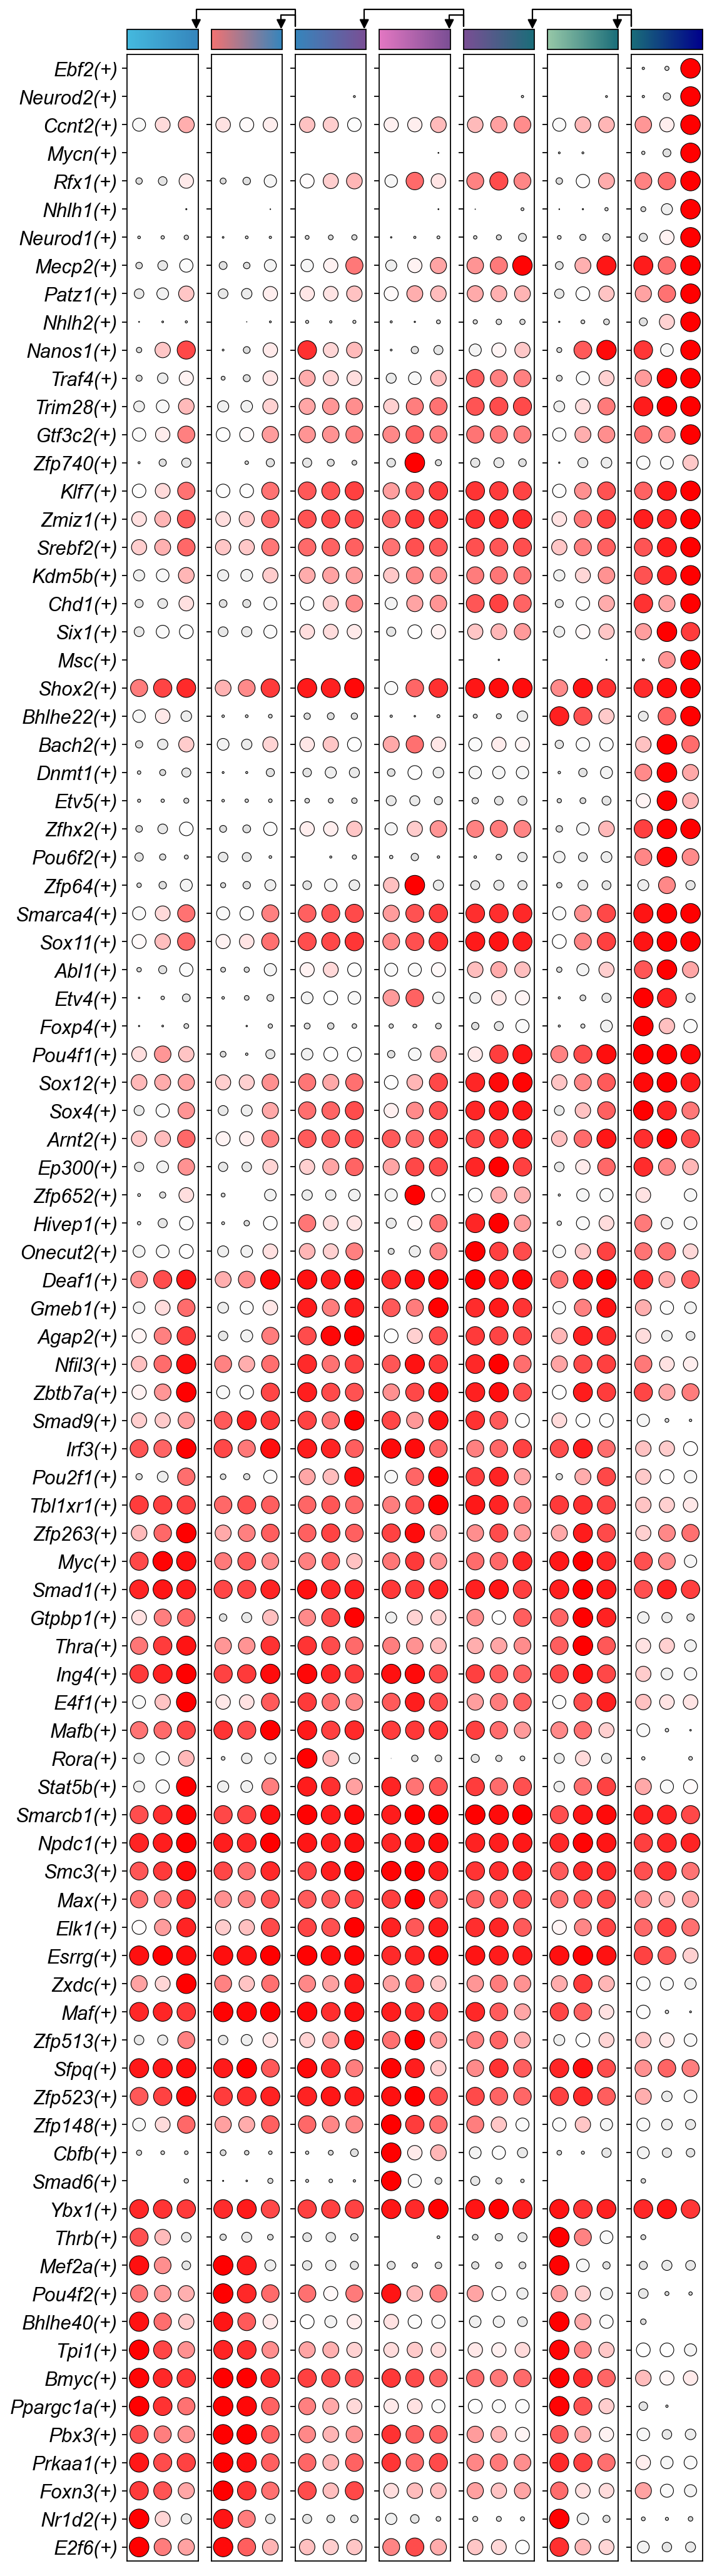

In [10]:
sc.set_figure_params()
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list("aspect",["lightgrey","white","red"])
reg=pd.read_csv("ordered_regulons.tsv",header=None).values.ravel()
plot_updown(adata,cmap=cmap,gglst=reg,rev=True,style="italic",link_seg=True)
plt.savefig("figures/fig3-A.pdf",bbox_inches="tight")

In [11]:
import loompy as lp
import pandas as pd
lf = lp.connect("scenic/scenic.loom", mode='r+', validate=False )
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons

In [12]:
res=pd.concat([pd.Series(r.tolist(),index=regulons.dtype.names) for r in regulons],axis=1)

res.columns=lf.row_attrs["gene"]

res.loc["Neurod1(+)"]==1

Adora1    False
Sntg1     False
Bai3      False
Gpr39     False
Obsl1     False
          ...  
Nanos1    False
Prdx3     False
Sfxn4     False
Gm7102    False
Csf2ra    False
Name: Neurod1(+), Length: 20699, dtype: bool

In [13]:
adata_genes=sc.read("data/adata_tree.h5ad")
adata_neurod1=adata_genes[:,res.columns[res.loc["Neurod1(+)"]==1]]

In [14]:
scf.tl.test_association(adata_neurod1,A_cut=.3,n_jobs=10)

test features for association with the trajectory
    single mapping : 100%|██████████| 143/143 [00:16<00:00,  8.60it/s]
    found 126 significant features (0:00:16) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [15]:
scf.tl.fit(adata_neurod1,n_jobs=10)

fit features associated with the trajectory
    single mapping : 100%|██████████| 126/126 [00:04<00:00, 25.60it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:05) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [16]:
scf.tl.cluster(adata_neurod1,knn=15,metric="correlation",device="gpu")

    clustering using grapheno
Finding 15 nearest neighbors using correlation metric and brute algorithm...
Neighbors computed in 3.9267947673797607 seconds...
Computing Jaccard similarity...
jaccard graph constructed in 0.12238669395446777 seconds...
Running Louvain modularity optimization...
grapheno completed in 4.375489234924316 seconds...
Communities detected: 4
Modularity: 0.5269885659217834
    finished (0:00:06) --> added
    .obsp['similarity'], pairwise similarity graph.
    .var['fit_clusters'], cluster assignments for features.
    .uns['fit_clusters'], parameters and modularity of the clustering.


In [17]:
adata_neurod1.var_names.name=None

In [18]:
adata_neurod1.uns=adata_genes.uns

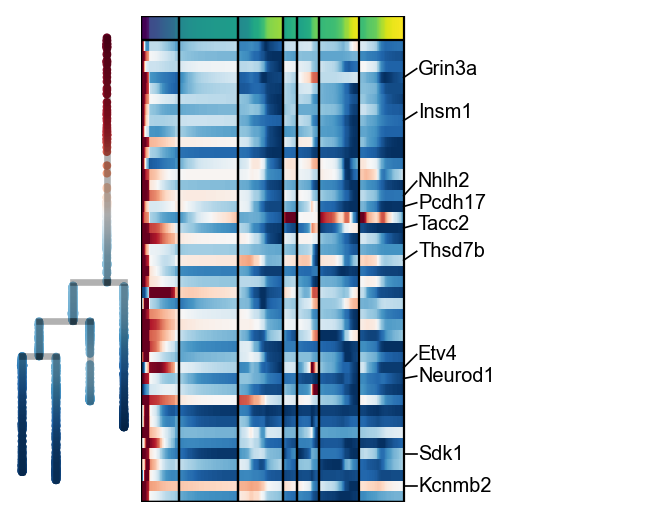

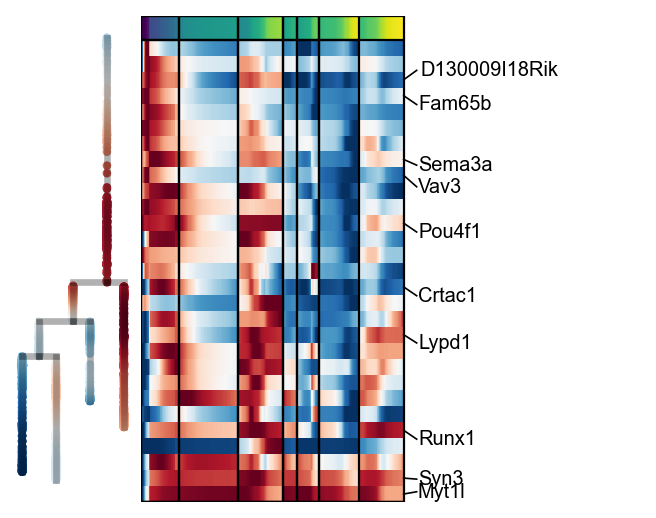

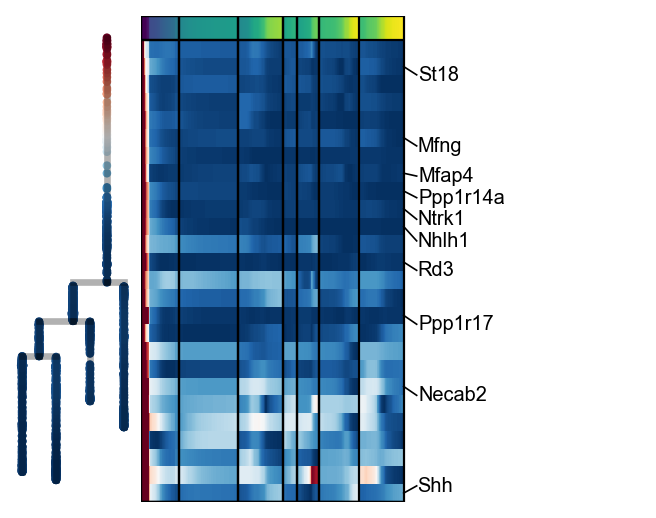

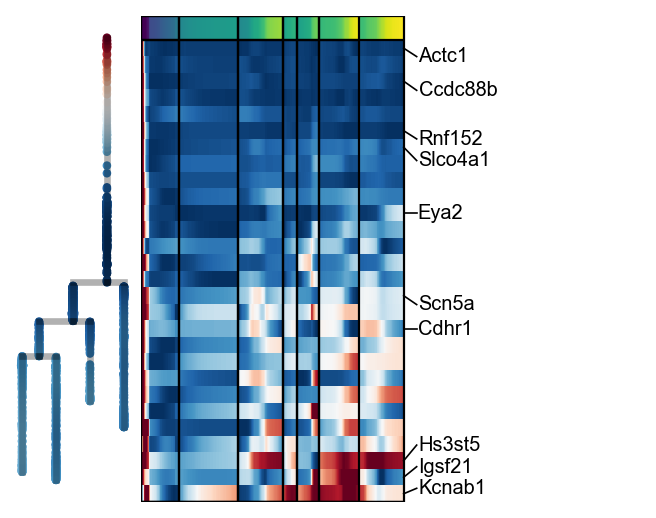

In [19]:
sc.set_figure_params(figsize=(1,4),dpi_save=600,frameon=False)
for c in adata_neurod1.var.fit_clusters.unique():
    scf.pl.trends(adata_neurod1,
                  adata_neurod1.var_names[adata_neurod1.var.fit_clusters==c],
                  basis="dendro",wspace=0,heatmap_space=.1,offset_names=.05)

In [20]:
Ic=adata_neurod1.var_names[adata_neurod1.var.fit_clusters==1]
neuro=adata_neurod1.var_names[adata_neurod1.var.fit_clusters==3]

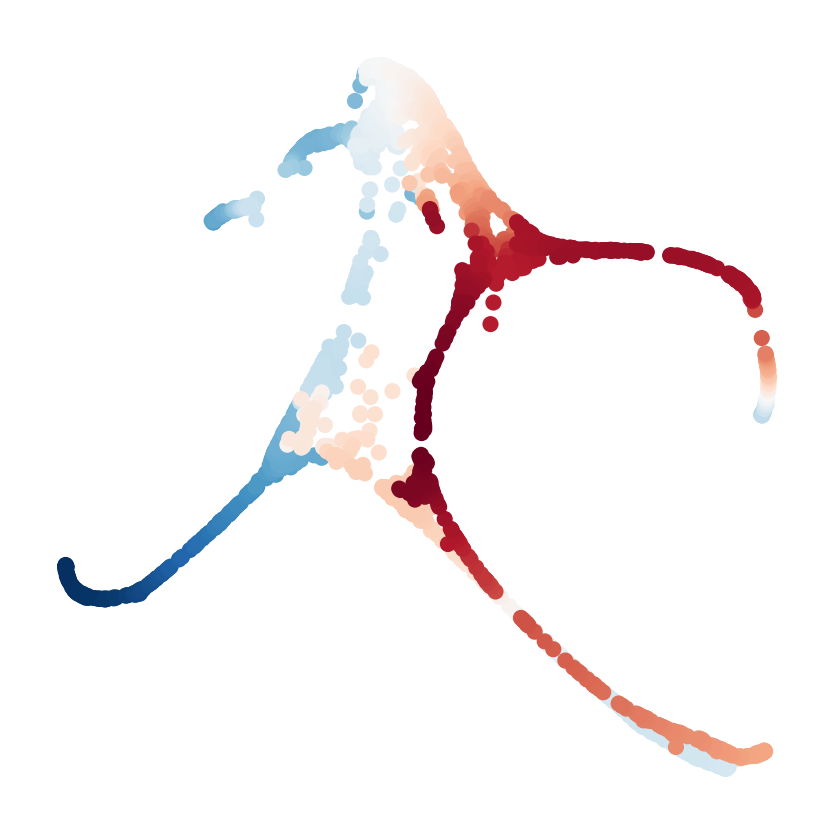

In [21]:
from scFates.plot.trajectory import remove_info
scv.set_figure_params(frameon=False,figsize=(3.5,3.5),dpi=150,dpi_save=600)
scf.pl.trends(adata_neurod1,Ic,basis="draw_graph_fa",plot_heatmap=False,show_segs=False,
              color="mean_trajectory")


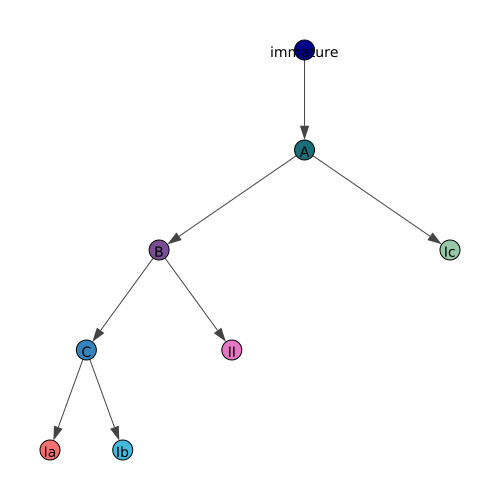

In [22]:
scf.pl.milestones(adata)

In [23]:
from scFates.tools.utils import get_X

In [24]:
def generate_module(adata,genes,cells=None,layer="fitted"):
    cells = adata.obs_names if cells is None else cells
    fitted=pd.DataFrame(get_X(adata,cells,genes,layer),
                        index=adata.obs_names,columns=genes).T
    fitted = fitted.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    return fitted.mean(axis=0)

In [25]:
adata_genes.obs["Ic_targets"]=generate_module(adata_neurod1,Ic,layer=None)
adata_genes.obs["neurogenesis_targets"]=generate_module(adata_neurod1,neuro,layer=None)

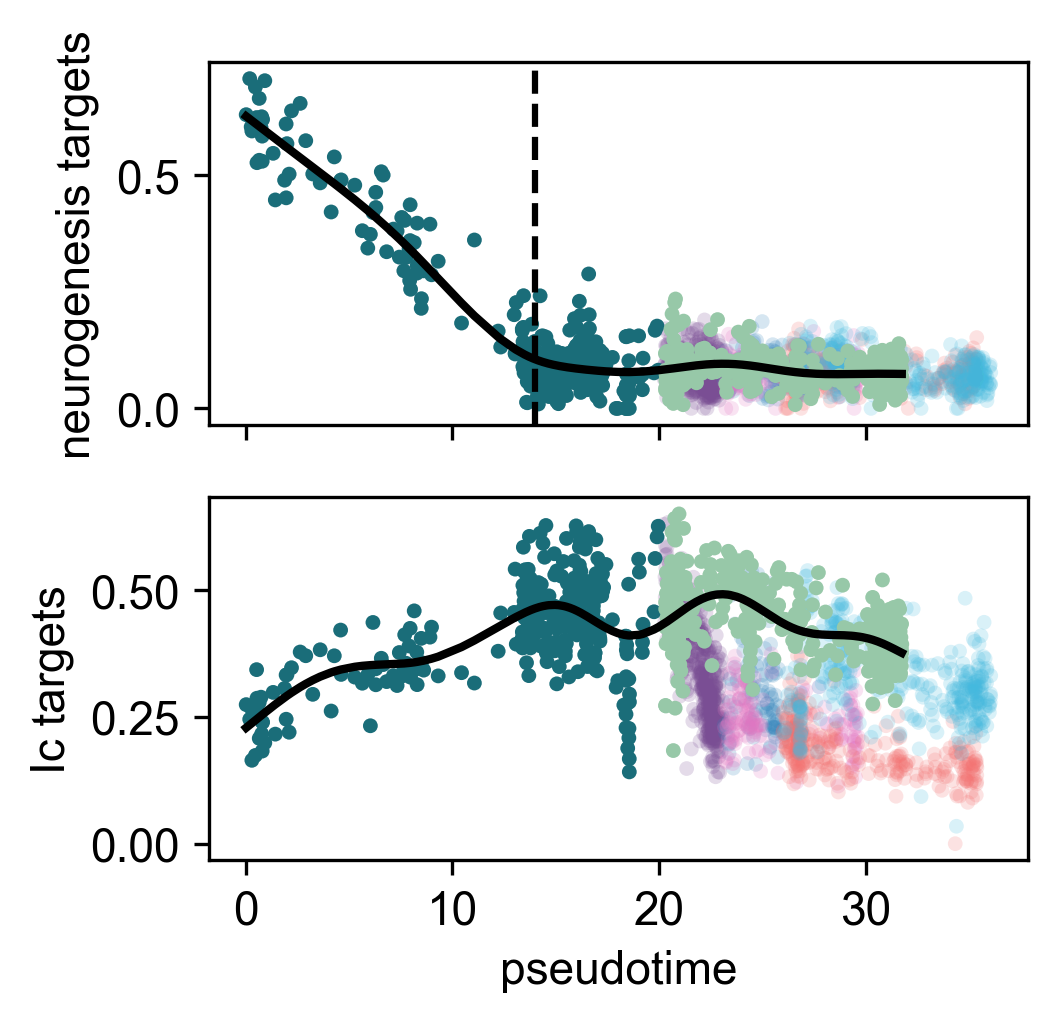

In [26]:
from scFates.tools.utils import importeR
from scFates.tools import getpath

a,b,rstats,rmgcv,Formula=importeR("test")
subset=getpath(adata_genes,"immature",["Ic"])
m = rmgcv.gam(
    Formula("neurogenesis_targets~s(t,bs='ts')"),
    data=subset,
    gamma=1.5,
)

df=pd.DataFrame({"t":subset.t.values,
              "fit":rmgcv.predict_gam(m)})
df.sort_values("t",inplace=True)

from kneed import KneeLocator
kneedle = KneeLocator(df.t, df.fit, S=1.0, curve="convex", direction="decreasing")

kneedle.knee

import scFates as scf

cols=pd.Series(adata_genes.uns["milestones_colors"],
          index=adata_genes.obs.milestones.cat.categories)

import matplotlib.pyplot as plt
fig ,axs = plt.subplots(2,1,sharex=True)
sc.pl.scatter(adata_genes,x="t",y="neurogenesis_targets",color="seg",show=False,ax=axs[0],alpha=.2,size=50,legend_loc="none")
sc.pl.scatter(adata_genes[subset.index],x="t",y="neurogenesis_targets",color="seg",show=False,ax=axs[0],size=50,legend_loc="none")
axs[0].plot(df.t,df.fit,linewidth=2,color="k")
axs[0].set_xlabel("")
axs[0].axvline(kneedle.knee,linestyle="--",color="k")
axs[0].set_title("")
axs[0].set_ylabel("neurogenesis targets")

m = rmgcv.gam(
    Formula("Ic_targets~s(t,bs='ts')"),
    data=subset,
    gamma=1.5,
)

df=pd.DataFrame({"t":subset.t.values,
              "fit":rmgcv.predict_gam(m)})
df.sort_values("t",inplace=True)

sc.pl.scatter(adata_genes,x="t",y="Ic_targets",color="seg",show=False,ax=axs[1],alpha=.2,size=50,legend_loc="none")
sc.pl.scatter(adata_genes[subset.index],x="t",y="Ic_targets",color="seg",show=False,ax=axs[1],size=50,legend_loc="none")
axs[1].set_title("")
axs[1].plot(df.t,df.fit,linewidth=2,color="k")
axs[1].set_xlabel("")
axs[1].set_xlabel("pseudotime")
axs[1].set_ylabel("Ic targets")
plt.savefig("figures/fig3-B.pdf",bbox_inches="tight")

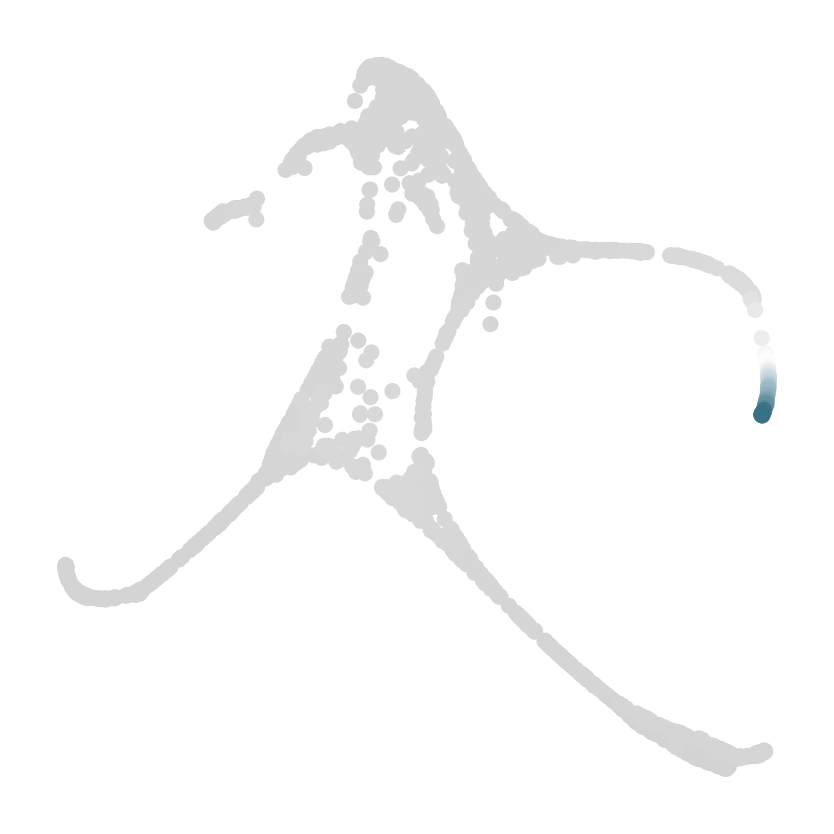

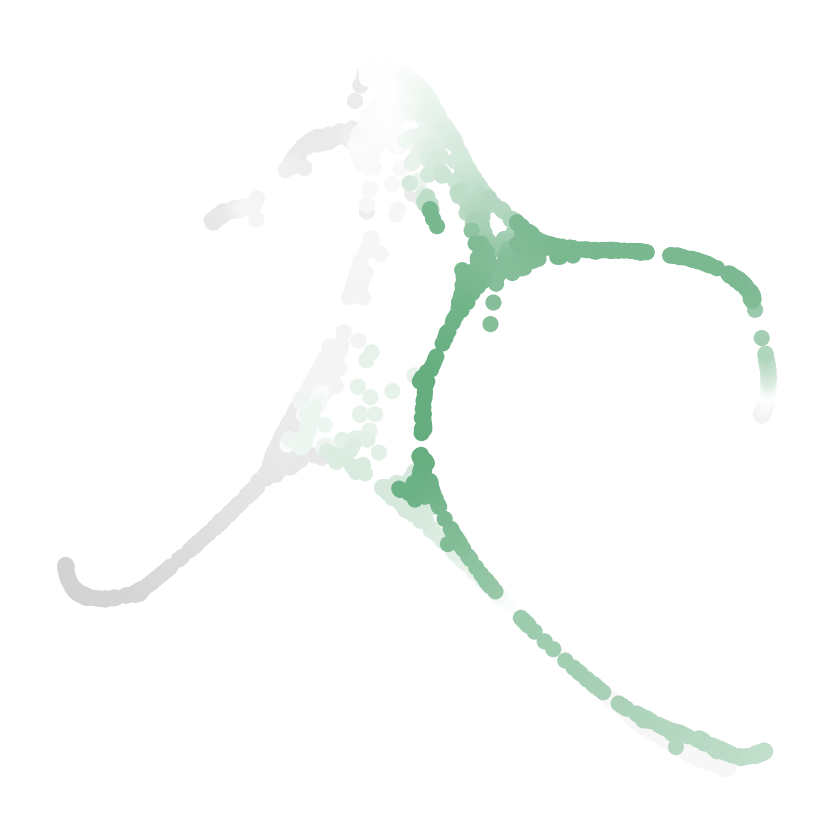

In [27]:
scv.set_figure_params(frameon=False,figsize=(3.5,3.5),dpi=150,dpi_save=600)
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list("aspect",["lightgrey","white",adata.uns["milestones_colors"][adata.obs.milestones.cat.categories=="immature"][0]])
cmap=LinearSegmentedColormap.from_list("aspect",["lightgrey","white","#397184"])
scf.pl.trends(adata_neurod1,neuro,basis="draw_graph_fa",plot_heatmap=False,show_segs=False,
              color="mean_trajectory",cmap=cmap,save="fig3-C1.pdf")
cmap=LinearSegmentedColormap.from_list("aspect",["lightgrey","white","#749780"])
cmap=LinearSegmentedColormap.from_list("aspect",["lightgrey","white","#65AD7F"])
scf.pl.trends(adata_neurod1,Ic,basis="draw_graph_fa",plot_heatmap=False,show_segs=False,
              color="mean_trajectory",cmap=cmap,save="fig3-C2.pdf")


In [28]:
interact=pd.DataFrame(0,index=["Neurod1"]+Ic.tolist()+neuro.tolist(),
             columns=["Neurod1"]+Ic.tolist()+neuro.tolist())

In [29]:
interact.loc[Ic,Ic]=.1
interact.loc[neuro,neuro]=.1
interact.loc["Neurod1",Ic]=1
interact.loc["Neurod1",neuro]=1

In [31]:
interact=interact.stack().reset_index()
import networkx as nx

In [32]:
nodes=pd.DataFrame("Neurod1",index=["Neurod1"]+Ic.tolist()+neuro.tolist(),columns=["group"])
nodes.loc[Ic,"group"]="neurogenesis"
nodes.loc[neuro,"group"]="Ic"
nodes.reset_index(inplace=True)
nodes.columns=["Id","group"]
nodes.to_csv("nodes.csv",index=None)

In [33]:
interact.columns=["Source","Target","weight"]
interact.to_csv("neurod1.csv",index=None)

In [102]:
scf.tl.test_fork(adata,root_milestone="immature",milestones=["II","Ia","Ib","Ic"],rescale=True,n_jobs=20)

testing fork
    single mapping
    Differential expression: 100%|██████████| 89/89 [00:16<00:00,  5.52it/s]
    test for upregulation for each leave vs root
    upreg Ic: 100%|██████████| 22/22 [00:00<00:00, 469.65it/s]
    finished (0:00:16) --> added 
    .uns['immature->II<>Ia<>Ib<>Ic']['fork'], DataFrame with fork test results.


In [206]:
df=adata.uns['immature->II<>Ia<>Ib<>Ic']['fork']

In [207]:
df=df.loc[df.signi_fdr==1]

In [141]:
df.loc[df.Ic==0]

II        Ia   Ic        Ib          de_p           fdr  \
Agap2(+)  -0.003560 -0.009560  0.0 -0.004318  2.764299e-04  2.460226e-02   
Mecp2(+)  -0.000703 -0.015254  0.0 -0.015804  6.167322e-14  5.488917e-12   
Nhlh2(+)  -0.002528 -0.006523  0.0 -0.006249  1.469859e-06  1.308175e-04   
Pou4f1(+) -0.042807 -0.080455  0.0 -0.028005  2.658712e-28  2.366254e-26   
Pou6f2(+) -0.013002 -0.009263  0.0 -0.008781  1.687979e-04  1.502301e-02   
Thra(+)   -0.032410 -0.007615  0.0 -0.000645  3.280997e-04  2.920087e-02   

           signi_p  signi_fdr      up_A           up_p  
Agap2(+)       1.0        1.0  0.000685   1.138555e-08  
Mecp2(+)       1.0        1.0 -0.001687   7.776054e-24  
Nhlh2(+)       1.0        1.0 -0.004883  5.201279e-123  
Pou4f1(+)      1.0        1.0 -0.001311   1.151540e-51  
Pou6f2(+)      1.0        1.0 -0.001208   4.158040e-12  
Thra(+)        1.0        1.0  0.003263   2.400040e-26

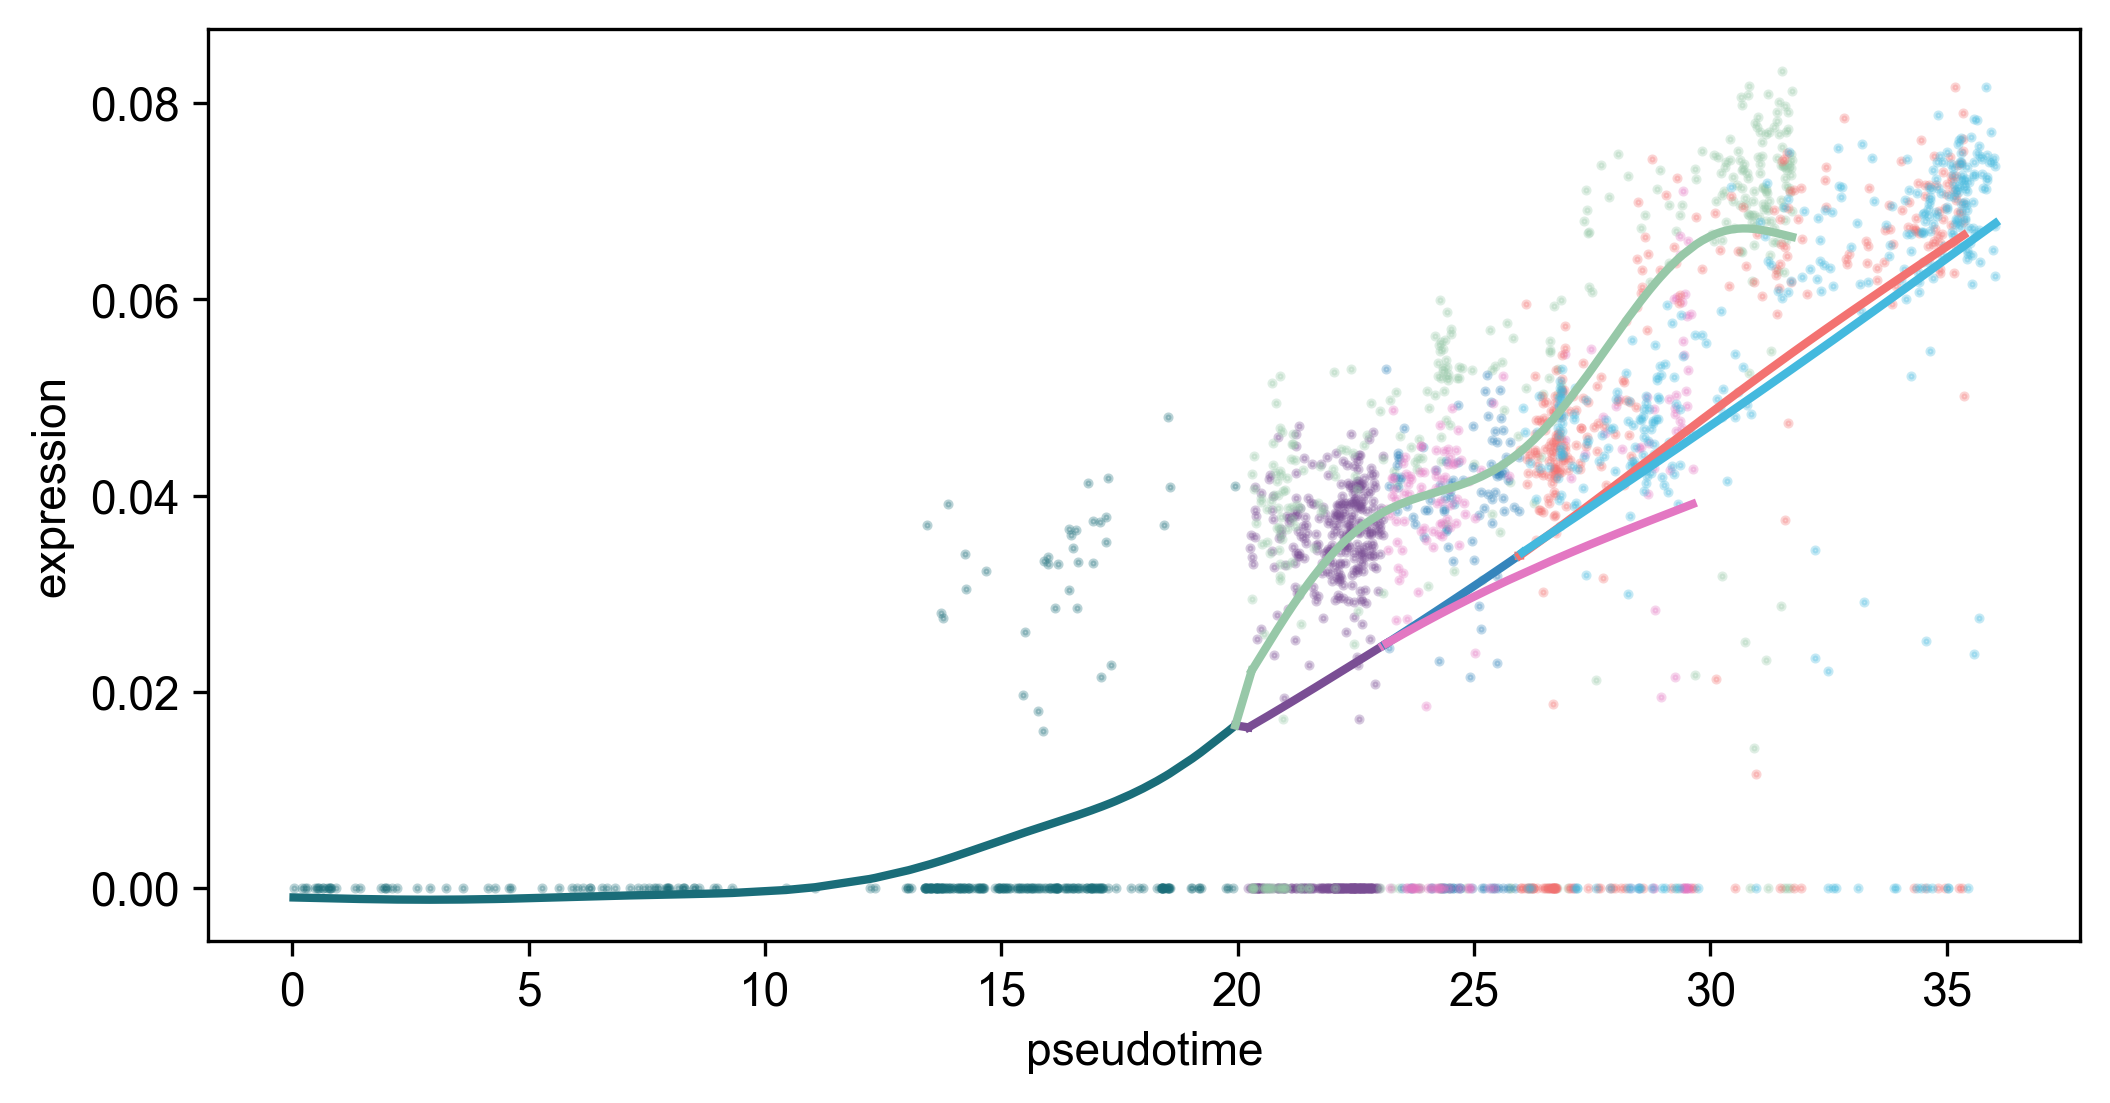

In [204]:
scf.pl.single_trend(adata,"Bhlhe40(+)",plot_emb=False)

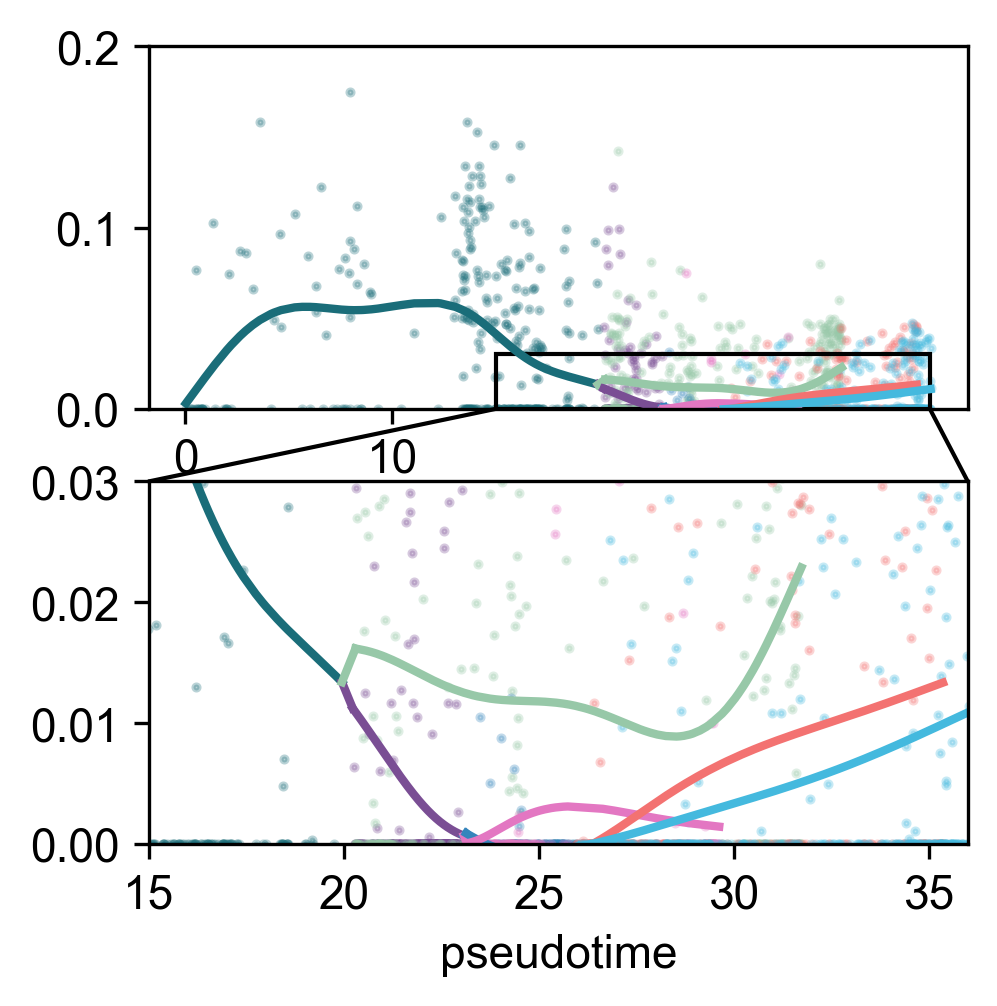

In [193]:
fig,(ax0,ax1)=plt.subplots(2,1,gridspec_kw =dict(hspace=.2))
scf.pl.single_trend(adata,"Pou6f2(+)",plot_emb=False,show=False,ax_trend=ax0)
ax0.set_ylim([0,.2])
ax0.set_xticks([0,10])
ax0.grid(b=False)
ax0.set_ylabel("")
ax0.set_xlabel("")
rec=Rectangle((15,0),21,0.03,fill=None, alpha=1)
ax0.add_artist(rec)

scf.pl.single_trend(adata,"Pou6f2(+)",plot_emb=False,show=False,ax_trend=ax1)
ax1.set_xlim([15,36])
ax1.set_ylim([0,0.03])

con1 = ConnectionPatch(xyA=(15, 0), coordsA="data", 
                       xyB=(15, 0.03), coordsB="data", axesA=ax0,axesB=ax1)
ax1.add_artist(con1)
con1 = ConnectionPatch(xyA=(36, 0), coordsA="data", 
                       xyB=(36, 0.03), coordsB="data", axesA=ax0,axesB=ax1)
ax1.add_artist(con1)
ax1.grid(b=False)
ax1.set_ylabel("")
plt.savefig("figures/fig3_Pou6f2.pdf",bbox_inches="tight")

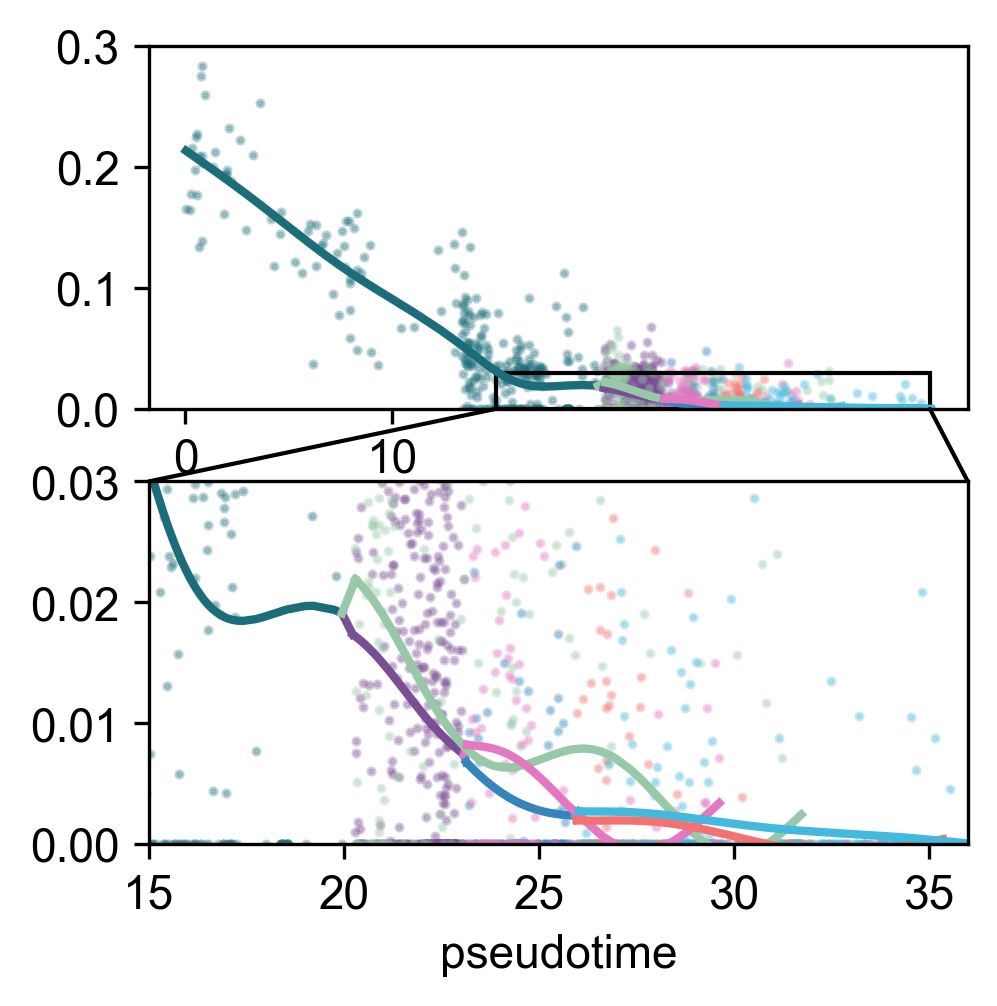

In [194]:
fig,(ax0,ax1)=plt.subplots(2,1,gridspec_kw =dict(hspace=.2))
scf.pl.single_trend(adata,"Nhlh2(+)",plot_emb=False,show=False,ax_trend=ax0)
ax0.set_ylim([0,.3])
ax0.set_xticks([0,10])
ax0.grid(b=False)
ax0.set_ylabel("")
ax0.set_xlabel("")
rec=Rectangle((15,0),21,0.03,fill=None, alpha=1)
ax0.add_artist(rec)

scf.pl.single_trend(adata,"Nhlh2(+)",plot_emb=False,show=False,ax_trend=ax1)
ax1.set_xlim([15,36])
ax1.set_ylim([0,0.03])

con1 = ConnectionPatch(xyA=(15, 0), coordsA="data", 
                       xyB=(15, 0.03), coordsB="data", axesA=ax0,axesB=ax1)
ax1.add_artist(con1)
con1 = ConnectionPatch(xyA=(36, 0), coordsA="data", 
                       xyB=(36, 0.03), coordsB="data", axesA=ax0,axesB=ax1)
ax1.add_artist(con1)
ax1.grid(b=False)
ax1.set_ylabel("")
plt.savefig("figures/fig3_Nhlh2.pdf",bbox_inches="tight")

In [245]:
%%bash
pdftk figures/fig3-A.pdf cat 1-endwest output fig3-A_rot.pdf
cat<<EOF >fig3.tex
\documentclass{article}
\usepackage{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=5mm,}
 
\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphbox,graphicx} 
\usepackage{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\large 

\fontsize{11pt}{11pt}\selectfont


\raggedright \textbf{a} progression of regulons over the tree
\includegraphics[width=\textwidth]{fig3-A_rot.pdf}

\begin{minipage}[!ht]{.74\textwidth}
\raggedright \textbf{b} Two regimes of \textit{Neurod1(+)} regulon activity
\includegraphics[width=\textwidth]{figures/fig3_auc_neurod.pdf}
\begin{minipage}[t]{.27\textwidth}
\raggedright \textbf{c} Neurogenesis targets
\includegraphics[width=\textwidth]{figures/trendsfig3-C1.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{.45\textwidth}
\raggedright \textbf{d} Network graph
\includegraphics[width=\textwidth]{Neurod1.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{.27\textwidth}
\raggedright \textbf{e} Ic targets
\includegraphics[width=\textwidth]{figures/trendsfig3-C2.pdf}
\end{minipage}\hfill

\raggedright \textbf{f} Validation of Neurod1 effect on mature SGN type proportions
\includegraphics[width=\textwidth]{sugg.jpg}
\end{minipage}\hfill
\begin{minipage}[!ht]{.26\textwidth}
\vspace{-85pt}
\raggedright \textbf{g} \textit{Pou6f2(+)} case
\includegraphics[width=\textwidth,align=t]{figures/fig3_Pou6f2.pdf}
\raggedright \textbf{h} \textit{Nhlh2(+)} case
\includegraphics[width=\textwidth]{figures/fig3_Nhlh2.pdf}

\end{minipage}\hfill

\hfill
\clearpage
EOF
echo "\end{document}" >> fig3.tex

xelatex --shell-escape fig3.tex
rm fig3.tex
rm fig3-A_rot.pdf
convert -flatten -density 300 fig3.pdf fig3.jpg

identify fig3.pdf

This is XeTeX, Version 3.14159265-2.6-0.999991 (TeX Live 2019/Debian) (preloaded format=xelatex)
 \write18 enabled.
entering extended mode
(./fig3.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption.sty
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption3.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/xetex.def))
(/usr/share/texlive/texmf-dist

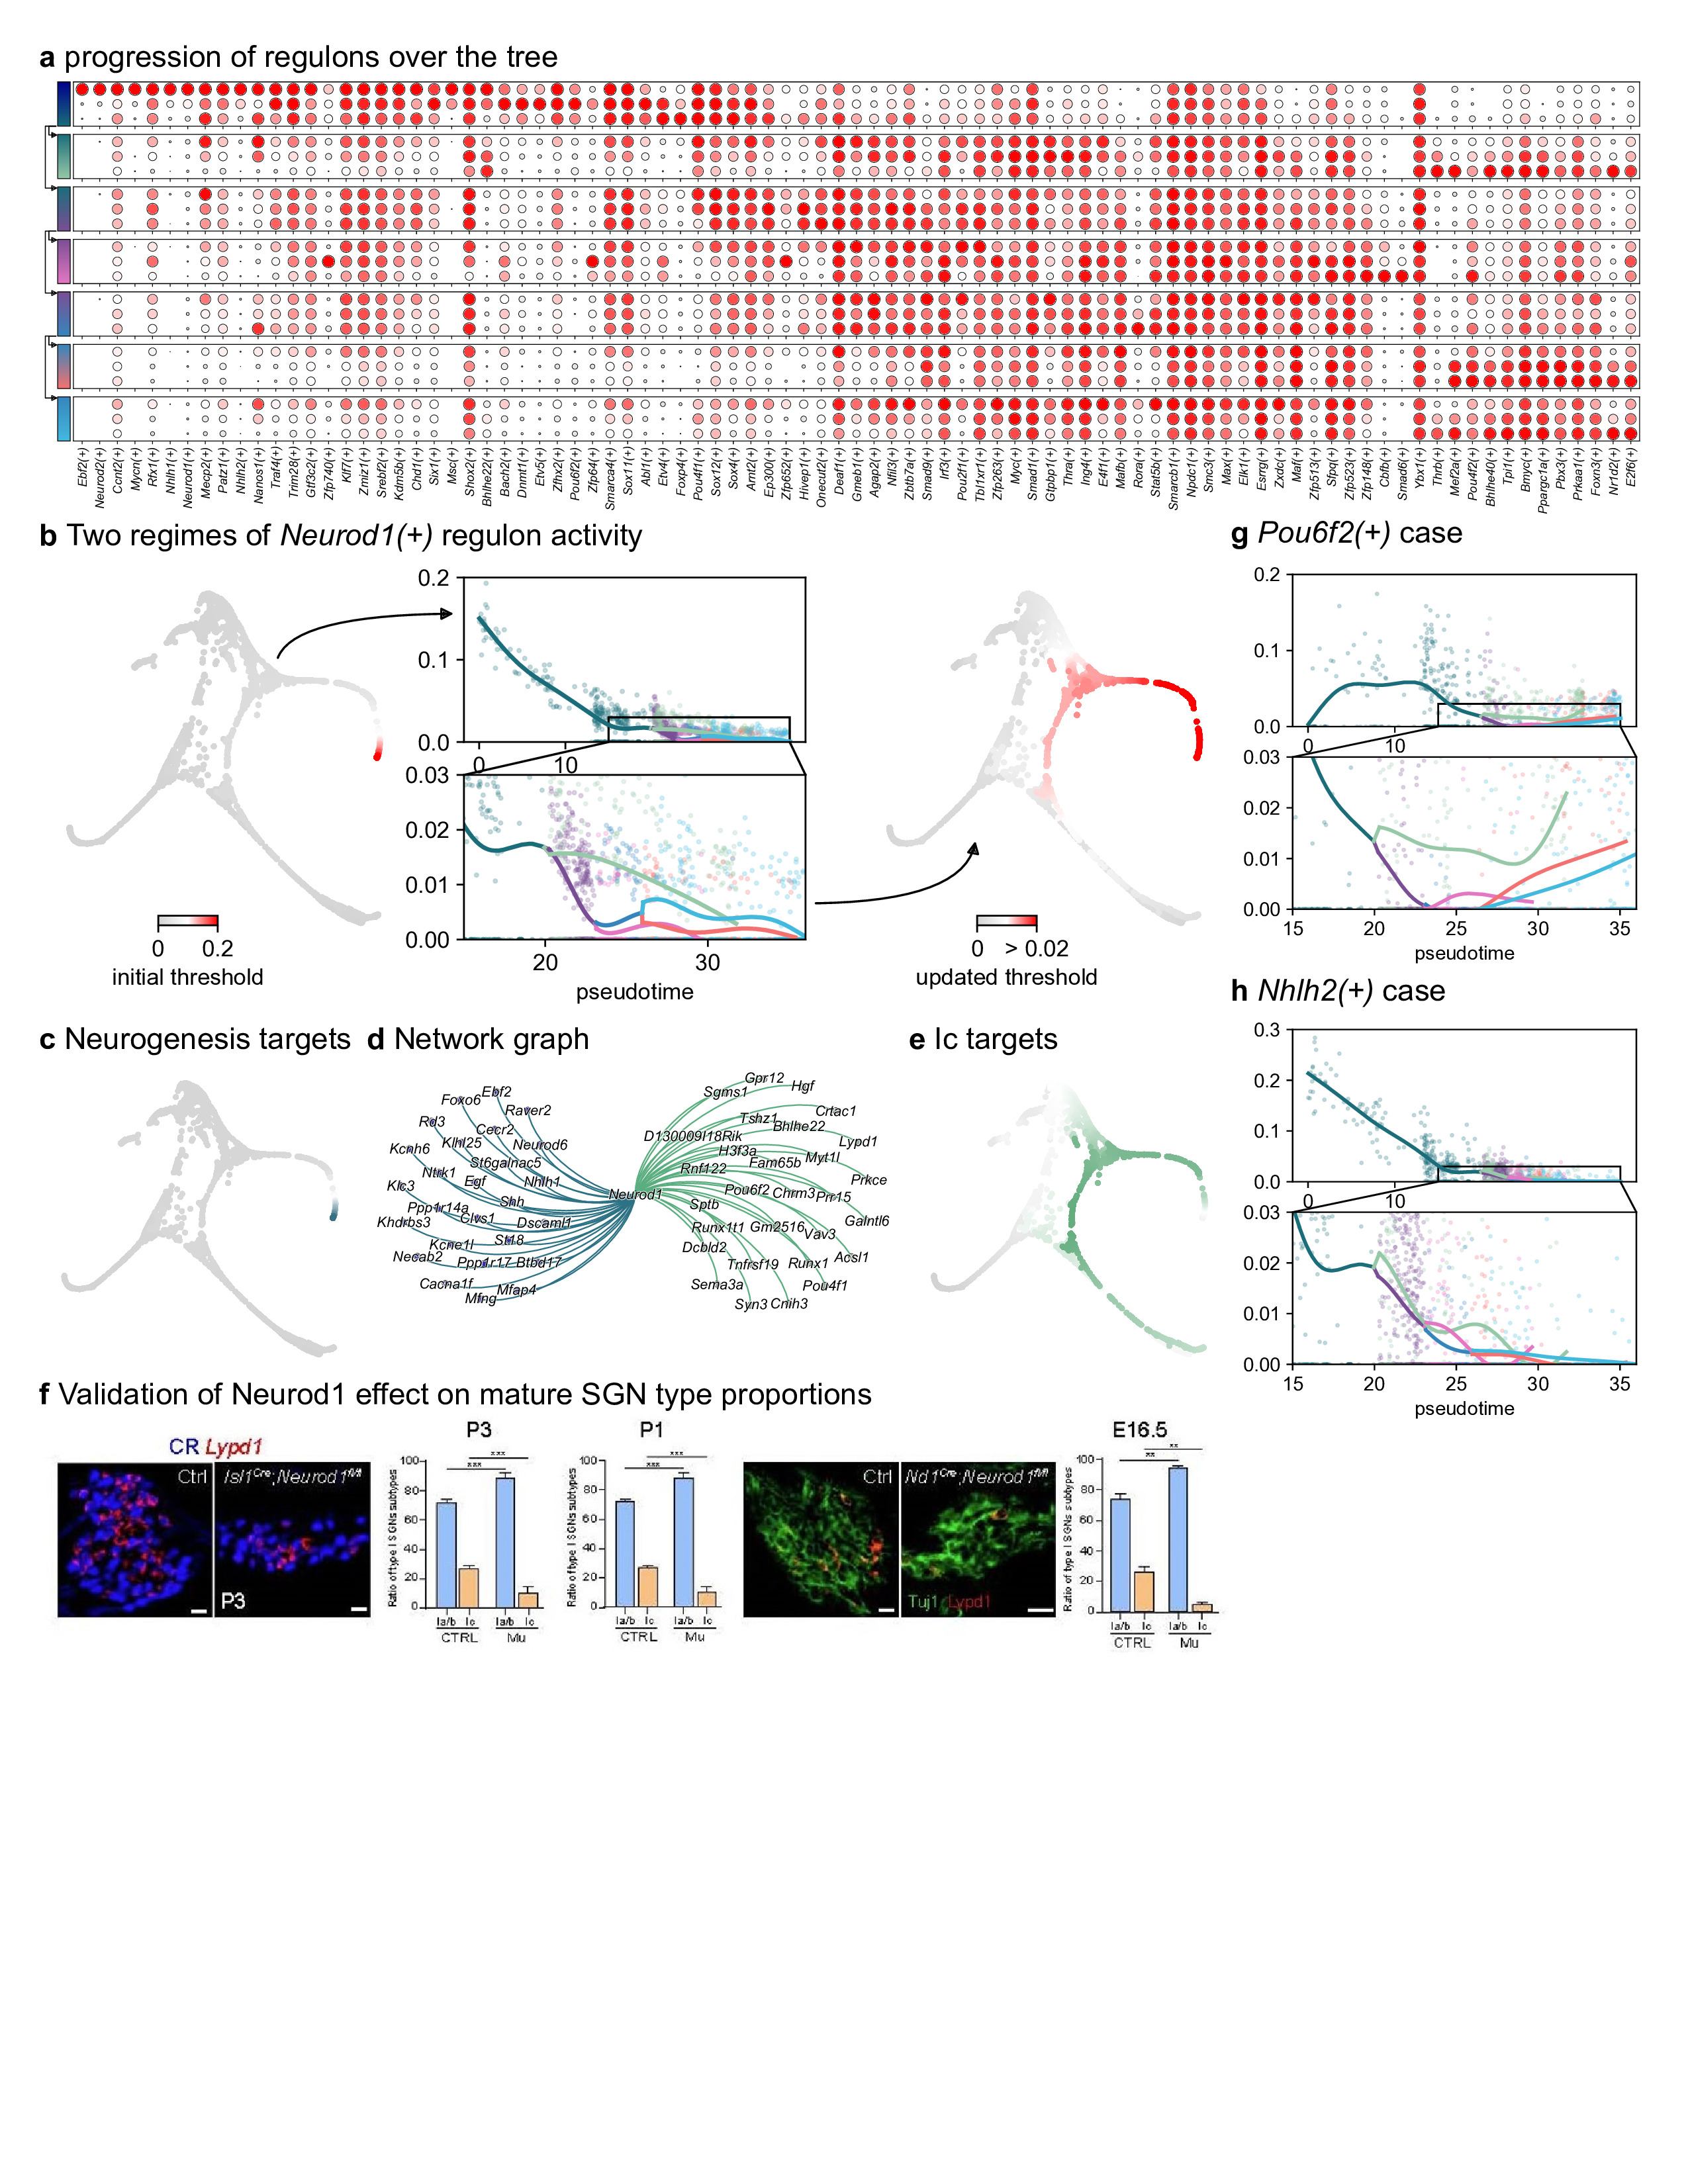

In [246]:
from IPython.display import Image
Image(filename='fig3.jpg') 